#20240105 
Sarah Fong

- Harmonize atac seq data across replicates w same treatment condition
- Check spread of ATAC-seq scores. 
- Call differentially accessible peaks?
- No. Chengyu has DEseq data for this, but we're going to predict the accessibility peak value. 

In [1]:
LOCAL = True

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
#import pybedtools as pbt
from scipy import stats
import seaborn as sns

if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    DATA_PATH = "/Users/sarahfong/Desktop/local_data/US/ATAC"
    section = "data_local"
else:
    DATA_PATH ="/wynton/group/ahituv/data/US-MPRA/ATAC/"
    section = "data_wynton"
import config_readwrite as crw

# open config

In [3]:
cfn_name = "config.atac.ini"
config, cfn = crw.read(cfn_name)

## add data paths

In [6]:
crw.check(config, section)

# write
config[section]["path"] = DATA_PATH
config[section]["data"] = "%(path)s/*narrowPeak*"

crw.write(config, cfn)

## input files

In [11]:
os.chdir(DATA_PATH)
peaks = glob.glob( "*.narrowPeak.gz")

In [80]:
data = {}
for file in peaks:
    # str split file
    cl, rep = file.split("-")[:2]
    
    names=["#chr", "start", "end", "name", 
           'score', "strand", "signal_val", "p", "q", "peak"]  # name columns
    
    df = pd.read_csv(file, sep='\t', header=None, names=names)  # open data
    print(cl, rep)#, df.shape)  # report info
    
    df["cl"], df["rep"] = cl, rep  # name columns with info
    df["exp"] = df["rep"].apply(lambda x: list(x)[0])  # add exposure column, 

    ###
    # centering - 400 bases from peaks
    ###
    
    
    filtered=df.copy()#.loc[(df["q"]>np.log10(0.0001)*-1)&
                #(df["score"]>=100)].copy()
    """
    fig, ax=plt.subplots(figsize=(4,4))
    sns.histplot(df["q"], label ="before filter")
    sns.histplot(filtered["q"], label ="after filter")
    ax.set(title=cl, xlim=(0,100))
    """

    # quantile normalize scores for each replicate. 
    filtered['score_q']=filtered["score"].rank(pct=True)
    
    # print some descrifilteredptive stats
    print(filtered[["score", "score_q"]].describe())

    # add to dictionary
    data[f'{cl+rep}'] = filtered

    # save filtered file
    out = f'{cl}.{rep}.filtered.peaks'
    #if os.path.exists(out) is False:
    filtered.to_csv(out, sep='\t', index=False)
    

BJ C2
               score        score_q
count  140365.000000  140365.000000
mean      176.779340       0.500004
std       385.833308       0.288037
min         1.000000       0.000702
25%        12.000000       0.217636
50%        54.000000       0.500769
75%       174.000000       0.749735
max     31389.000000       1.000000
K562 C2
               score        score_q
count  121313.000000  121313.000000
mean      281.739014       0.500004
std       700.759629       0.288146
min         1.000000       0.048470
25%        14.000000       0.248910
50%        46.000000       0.500194
75%       209.000000       0.751350
max     46985.000000       1.000000
K562 T3
               score        score_q
count  105334.000000  105334.000000
mean      367.800853       0.500005
std       771.843564       0.288594
min         1.000000       0.000328
25%        29.000000       0.247665
50%        91.000000       0.496691
75%       335.000000       0.750456
max     47193.000000       1.000000
BJ T3


### concat data

In [70]:
df = pd.concat(data.values())

print(df.shape)

df.head()

(3358581, 14)


,#chr,start,end,name,score,strand,signal_val,p,q,peak,cl,rep,exp,score_q
0,chr1,10003,10659,BJ-C2-ATAC-q.7_peak_1,740,.,25.07460,77.54320,74.06110,85,BJ,C2,C,0.946935
1,chr1,11189,11335,BJ-C2-ATAC-q.7_peak_2,100,.,6.78902,12.56320,10.04810,121,BJ,C2,C,0.633648
2,chr1,15594,15729,BJ-C2-ATAC-q.7_peak_3,29,.,4.19675,5.18180,2.97637,60,BJ,C2,C,0.367556
3,chr1,21915,22092,BJ-C2-ATAC-q.7_peak_4,22,.,3.64674,4.36549,2.22666,65,BJ,C2,C,0.290696
4,chr1,28650,28807,BJ-C2-ATAC-q.7_peak_5,12,.,2.90225,3.31924,1.27812,7,BJ,C2,C,0.217636


## filter peaks criteria
- q < 0.0001 (arbitrary)
- score >=100 (arbitrary)? What is the score again?

other ideas:
- reproducible discovery rate
- Frip - fraction of reads in peak score. 
- REMOVE blacklist!!! (mitochondrial reads)

other followup
- Get deseq2 calls - for classification model?
- quantile normalization of scores. 

## check raw score distribution, filtered for q-value, score<100

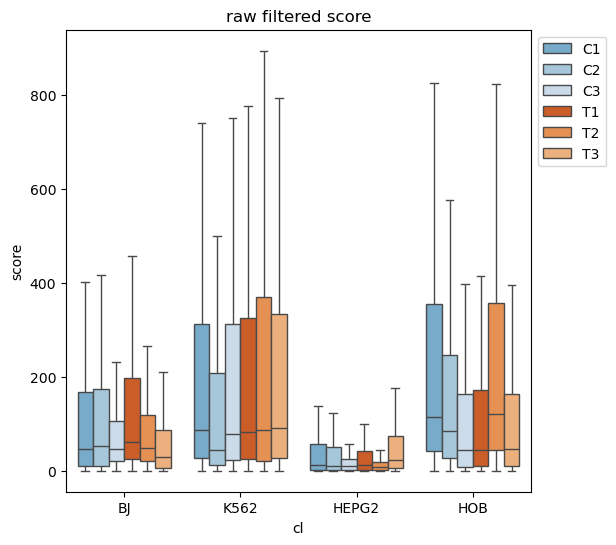

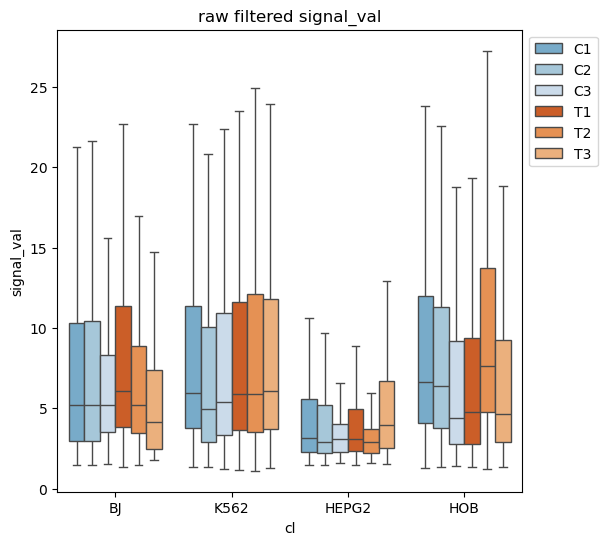

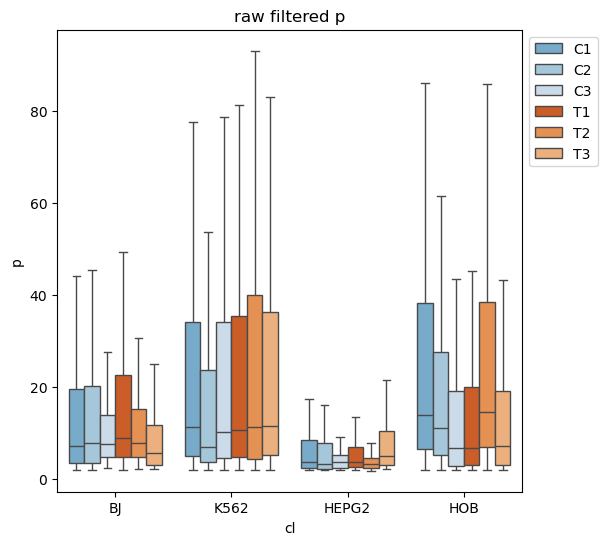

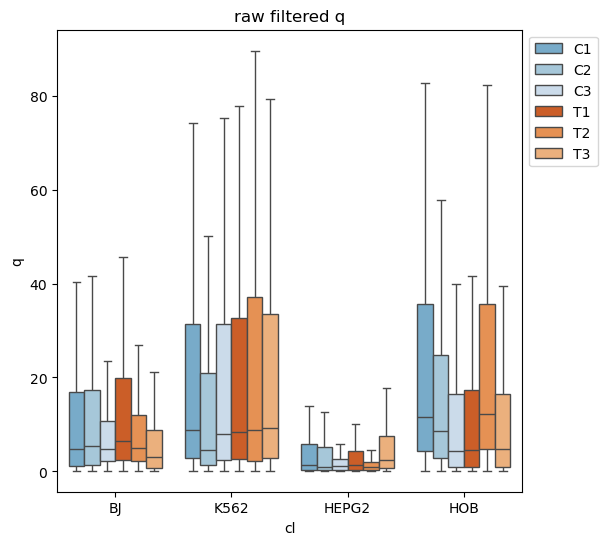

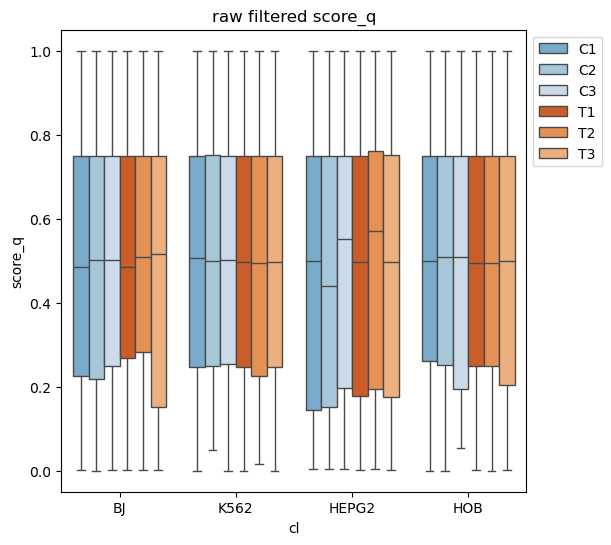

In [71]:
vals = ["score", "signal_val", "p", "q", "score_q"]
x="cl"

data=df#.loc[df["cl"]=="BJ"]#.sample(frac=0.1)
hue ="rep"
hue_order = ['C1', 'C2', 'C3', 'T1', 'T2', 'T3']
palette='tab20c'

for y in vals:
    y=y
    title= f"raw filtered {y}"

    fig, ax=plt.subplots(figsize=(6,6))
    sns.boxplot(x=x, y=y, data=data, 
                hue=hue, hue_order=hue_order, 
                palette=plt.cm.tab20c.colors[1:], 
                showfliers=False)
    ax.set(title=title)
    ax.legend(bbox_to_anchor=(1,1))

## count peaks per cell-type, rep

In [72]:
counts = df.groupby(["cl","exp", "rep"])["score"].count().reset_index()

counts =counts.rename(columns={"score":"counts"})
counts["counts"].describe()  # summarize stats for all count data 

count        24.000000
mean     139940.875000
std       45415.927236
min       65066.000000
25%      104792.250000
50%      131109.500000
75%      173251.250000
max      241002.000000
Name: counts, dtype: float64

In [73]:
# summary of counts across replicates
counts.groupby(["cl", "exp"])["counts"].describe()

count           mean           std       min       25%       50%  \
cl    exp                                                                     
BJ    C      3.0  118003.000000  46028.337131   65066.0  102715.5  140365.0   
      T      3.0  104844.666667  23871.575238   82377.0   92313.0  102249.0   
HEPG2 C      3.0  209395.000000  29890.732828  181583.0  193591.5  205600.0   
      T      3.0  160709.000000  62236.758568   96502.0  130679.5  164857.0   
HOB   C      3.0  149526.000000  33187.079097  116879.0  132675.0  148471.0   
      T      3.0  160648.000000  24739.426166  132311.0  151998.5  171686.0   
K562  C      3.0  110050.000000  16459.927065   91160.0  104418.5  117677.0   
      T      3.0  106351.333333   3796.639874  103167.0  104250.5  105334.0   

                75%       max  
cl    exp                      
BJ    C    144471.5  148578.0  
      T    116078.5  129908.0  
HEPG2 C    223301.0  241002.0  
      T    192812.5  220768.0  
HOB   C    165849.5  183228.0  
      T    174816.5  177947.0  
K562  C    119495.0  121313.0  
      T    107943.5  110553.0

In [76]:
x="cl"
y="counts"
data=counts
hue="rep"
title = "peak counts, filtered on q<0.001 and score >100"

[Text(0.5, 1.0, 'peak counts, filtered on q<0.001 and score >100')]

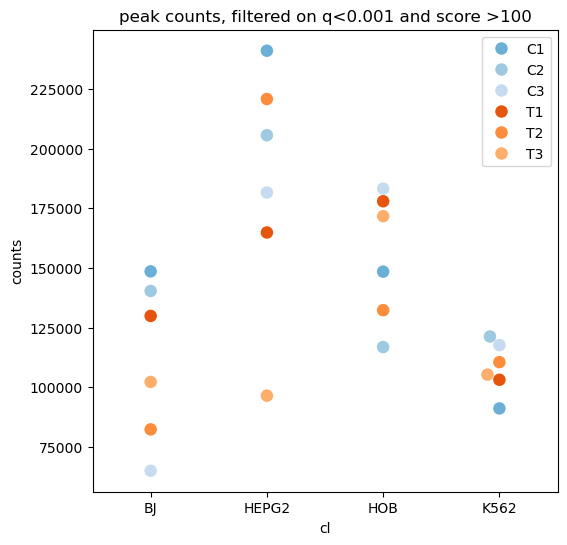

In [77]:
fig, ax = plt.subplots(figsize=(6,6))
sns.swarmplot(x=x,y=y,data=data, 
              hue=hue, hue_order=hue_order, 
              palette=plt.cm.tab20c.colors[1:],
             size=9)
ax.legend(bbox_to_anchor=(1,1))
ax.set(title=title)

# multi intersect

In [81]:
filtered_ = glob.glob("*filtered.peaks") # get all the files

reps = {}
for f in filtered_:

    # get cl and replicate
    cl, rep = f.split(".")[:2]

    # get exposure - treated or control
    exposure=list(rep)[0]

    # add cl+exposure and file to dictionary
    key=f"{cl}.{exposure}"

    
    if key not in reps:
        print("new key", key, f)
        reps[key] = [f]
    else:
        rep_list = reps[key]
        rep_list.append(f)
        reps[key] = rep_list
    

new key BJ.T BJ.T2.filtered.peaks
new key K562.T K562.T2.filtered.peaks
new key HEPG2.C HEPG2.C1.filtered.peaks
new key HOB.T HOB.T1.filtered.peaks
new key HOB.C HOB.C3.filtered.peaks
new key BJ.C BJ.C1.filtered.peaks
new key K562.C K562.C1.filtered.peaks
new key HEPG2.T HEPG2.T2.filtered.peaks


## bedtoosl multiintersect command and filtering for peaks in all three datasets. 

In [82]:
consensus_files = {}
for key, val in reps.items():
    out = key + ".filtered.multi.bed"  # file to write to
    
    # build bedtools multi command
    cmd =["bedtools multiinter -i"]
    cmd.extend(val)
    cmd.append(f" > {out}")
    cmd = " ".join(cmd)

    # perform multi-intersect, if not already done.
    #if os.path.exists(out) is False:
    os.system(cmd)

    # get peaks found in all 3 datasets
    consen_out = key + ".filtered.multi.3.bed"
    test = pd.read_csv(out, sep='\t', header=None)

    # fitler
    consen = test.loc[test[3]==3].copy() # keep only 3 overlaps
    
    # colunm formatting
    consen.columns=["#chr", "start", "end", "count", "reps", "rep1", 'rep2', "rep3"]
    consen["len"] = consen["end"] - consen["start"] # compute lengths of overlapping peaks
    consen["cl.exp"]= key  # add key identity
    
    # filter - peak overlaps all three datasets
    print(key, consen["len"].describe())  # summary stat of length
    
    # write
    consen[["#chr", "start", "end", "count", "len","cl.exp"]].to_csv(consen_out, sep='\t', index=False)

    consensus_files[consen_out] = consen[["#chr", "start", "end", "count", "len","cl.exp"]]

BJ.T count    51725.000000
mean       305.196114
std        177.983297
min          1.000000
25%        176.000000
50%        260.000000
75%        392.000000
max       2570.000000
Name: len, dtype: float64
K562.T count    71872.000000
mean       428.308855
std        272.155976
min          1.000000
25%        232.000000
50%        353.000000
75%        545.000000
max       3077.000000
Name: len, dtype: float64
HEPG2.C count    61761.000000
mean       271.803630
std        181.014827
min          1.000000
25%        151.000000
50%        221.000000
75%        350.000000
max       2904.000000
Name: len, dtype: float64
HOB.T count    98888.000000
mean       333.999626
std        215.529737
min          1.000000
25%        179.000000
50%        273.000000
75%        426.000000
max       3595.000000
Name: len, dtype: float64
HOB.C count    90525.000000
mean       362.531676
std        229.920536
min          1.000000
25%        195.000000
50%        300.000000
75%        465.000000
max   

In [83]:
con = pd.concat(consensus_files.values())
print(con.shape)
con.head()

(537097, 6)


,#chr,start,end,count,len,cl.exp
0,chr1,10002,10430,3,428,BJ.T
13,chr1,29049,29421,3,372,BJ.T
21,chr1,34497,35048,3,551,BJ.T
34,chr1,96572,96789,3,217,BJ.T
47,chr1,143876,144081,3,205,BJ.T


## consensus peak lengths per replicate

<Axes: xlabel='len', ylabel='Density'>

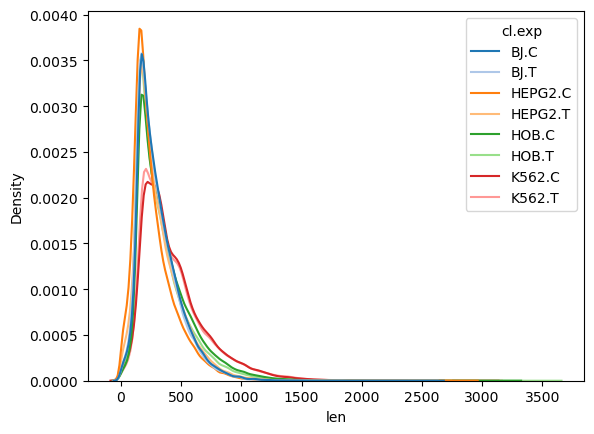

In [84]:
# consensus peak lengths per replicate
sns.kdeplot(x="len", data=con.sort_values(by="cl.exp"), hue="cl.exp", common_norm=False, palette="tab20")

In [89]:
# get mean scores for consensus peaks by back-intersecting w original data. 
for key in consensus_files.keys():
    group = ".".join(key.split(".")[:2])
    for peak_file in filtered_:
        if group in peak_file:
            cmd = " ".join(["bedtools intersect -a", 
                    key, 
                   "-b", 
                    peak_file
                   ])
            print(cmd)

bedtools intersect -a BJ.T.filtered.multi.3.bed -b BJ.T2.filtered.peaks
bedtools intersect -a BJ.T.filtered.multi.3.bed -b BJ.T3.filtered.peaks
bedtools intersect -a BJ.T.filtered.multi.3.bed -b BJ.T1.filtered.peaks
bedtools intersect -a K562.T.filtered.multi.3.bed -b K562.T2.filtered.peaks
bedtools intersect -a K562.T.filtered.multi.3.bed -b K562.T3.filtered.peaks
bedtools intersect -a K562.T.filtered.multi.3.bed -b K562.T1.filtered.peaks
bedtools intersect -a HEPG2.C.filtered.multi.3.bed -b HEPG2.C1.filtered.peaks
bedtools intersect -a HEPG2.C.filtered.multi.3.bed -b HEPG2.C2.filtered.peaks
bedtools intersect -a HEPG2.C.filtered.multi.3.bed -b HEPG2.C3.filtered.peaks
bedtools intersect -a HOB.T.filtered.multi.3.bed -b HOB.T1.filtered.peaks
bedtools intersect -a HOB.T.filtered.multi.3.bed -b HOB.T3.filtered.peaks
bedtools intersect -a HOB.T.filtered.multi.3.bed -b HOB.T2.filtered.peaks
bedtools intersect -a HOB.C.filtered.multi.3.bed -b HOB.C3.filtered.peaks
bedtools intersect -a HOB.

In [ ]:
%%bash
bedtools intersect -a HEPG2.T.filtered.multi.3.bed -b HEPG2.T1.filtered.peaks -wa -wb -header

In [94]:
43783

43783